In [7]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import (
    StratifiedKFold, cross_validate, train_test_split, 
    GridSearchCV, cross_val_score
)
from sklearn.linear_model import LogisticRegression, ElasticNetCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_score, recall_score, 
    f1_score, classification_report, confusion_matrix
)
import xgboost as xgb
import lightgbm as lgb
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

print("NESTED CV OTIMIZADO - ALGORITMOS RÁPIDOS PRIMEIRO")
print("=" * 60)

# Carregar dados
train_df = pd.read_csv('/Users/marcelosilva/Desktop/copia2 - artigo peer/predição_amamentação/10 - Robust e regularizacao/train_set.csv')

# Preparar dados
X = train_df.drop(['aleitamento_materno_exclusivo', 'id_anon'], axis=1)
y = train_df['aleitamento_materno_exclusivo']

print(f"Dataset: {X.shape[0]} observações, {X.shape[1]} features")
print(f"Target balanceamento: {y.value_counts(normalize=True).round(3).to_dict()}")

# Função para calcular Bootstrap 95% CI
def bootstrap_ci(y_true, y_pred_proba, y_pred, n_bootstrap=1000, alpha=0.05):
    """Calcula intervalos de confiança bootstrap 95% para todas as métricas"""
    np.random.seed(42)  # Para reprodutibilidade
    n_samples = len(y_true)
    
    bootstrap_metrics = {
        'auc': [], 'accuracy': [], 'precision': [], 'recall': [], 
        'f1': [], 'specificity': [], 'npv': [], 'ppv': []
    }
    
    for _ in range(n_bootstrap):
        # Bootstrap sample
        indices = np.random.choice(n_samples, n_samples, replace=True)
        y_true_boot = y_true.iloc[indices] if hasattr(y_true, 'iloc') else y_true[indices]
        y_pred_boot = y_pred[indices]
        y_pred_proba_boot = y_pred_proba[indices]
        
        # Calcular métricas para esta amostra bootstrap
        try:
            tn, fp, fn, tp = confusion_matrix(y_true_boot, y_pred_boot).ravel()
            
            bootstrap_metrics['auc'].append(roc_auc_score(y_true_boot, y_pred_proba_boot))
            bootstrap_metrics['accuracy'].append(accuracy_score(y_true_boot, y_pred_boot))
            bootstrap_metrics['precision'].append(precision_score(y_true_boot, y_pred_boot))
            bootstrap_metrics['recall'].append(recall_score(y_true_boot, y_pred_boot))
            bootstrap_metrics['f1'].append(f1_score(y_true_boot, y_pred_boot))
            bootstrap_metrics['specificity'].append(tn / (tn + fp) if (tn + fp) > 0 else 0)
            bootstrap_metrics['npv'].append(tn / (tn + fn) if (tn + fn) > 0 else 0)
            bootstrap_metrics['ppv'].append(tp / (tp + fp) if (tp + fp) > 0 else 0)
        except:
            # Skip problematic bootstrap samples
            continue
    
    # Calcular intervalos de confiança
    ci_results = {}
    for metric, values in bootstrap_metrics.items():
        if len(values) > 0:
            lower = np.percentile(values, 100 * alpha/2)
            upper = np.percentile(values, 100 * (1 - alpha/2))
            ci_results[f'{metric}_ci_lower'] = lower
            ci_results[f'{metric}_ci_upper'] = upper
            ci_results[f'{metric}_ci'] = f"[{lower:.3f}, {upper:.3f}]"
    
    return ci_results

# Função para calcular todas as métricas
def calculate_comprehensive_metrics(y_true, y_pred, y_pred_proba, include_ci=False):
    """Calcula todas as métricas necessárias"""
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    metrics = {
        'auc': roc_auc_score(y_true, y_pred_proba),
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred),
        'recall': recall_score(y_true, y_pred),  # = sensitivity
        'f1': f1_score(y_true, y_pred),
        'specificity': tn / (tn + fp),
        'npv': tn / (tn + fn) if (tn + fn) > 0 else 0,  # Negative Predictive Value
        'ppv': tp / (tp + fp) if (tp + fp) > 0 else 0   # Positive Predictive Value = Precision
    }
    
    # Adicionar intervalos de confiança se solicitado
    if include_ci:
        ci_results = bootstrap_ci(y_true, y_pred_proba, y_pred)
        metrics.update(ci_results)
    
    return metrics

# Variáveis para análise de subgrupos
subgroup_vars = {
    'regiao': ['regiao_Centro-Oeste', 'regiao_Nordeste', 'regiao_Norte', 'regiao_Sudeste', 'regiao_Sul'],
    'educacao': ['educacao_Fundamental', 'educacao_Médio', 'educacao_Sem estudo', 'educacao_Superior'],
    'cor_mae': ['cor_mae_Branca', 'cor_mae_Outras', 'cor_mae_Parda (mulata, cabocla, cafuza, mameluca ou mestiça)', 'cor_mae_Preta'],
    'beneficio': ['q01_recebe_beneficio']
}

# SPLIT INICIAL 80/20
print(f"\n1. SPLIT INICIAL: 80% Desenvolvimento / 20% Teste Final")
print("-" * 50)

X_dev, X_holdout, y_dev, y_holdout = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"   Desenvolvimento: {X_dev.shape[0]} observações")
print(f"   Hold-out final: {X_holdout.shape[0]} observações")

# ALGORITMOS OTIMIZADOS (RÁPIDOS PRIMEIRO)
print(f"\n2. ALGORITMOS - ORDEM OTIMIZADA")
print("-" * 50)

# Grids simplificados para velocidade
algorithms = {
    # ALGORITMOS RÁPIDOS (executar primeiro)
    'LogisticRegression': {
        'model': LogisticRegression(random_state=42, max_iter=1000),
        'params': {
            'model__C': [0.01, 0.1, 1, 10, 100],
            'model__penalty': ['l1', 'l2'],
            'model__solver': ['liblinear']
        }
    },
    'RandomForest': {
        'model': RandomForestClassifier(random_state=42, n_jobs=-1),
        'params': {
            'model__n_estimators': [100, 200],
            'model__max_depth': [5, 7, None],
            'model__min_samples_split': [2, 5],
            'model__min_samples_leaf': [1, 2],
            'model__max_features': ['sqrt', 'log2']
        }
    },
    'XGBoost': {
        'model': xgb.XGBClassifier(random_state=42, eval_metric='logloss'),
        'params': {
            'model__n_estimators': [100, 200],
            'model__learning_rate': [0.05, 0.1, 0.2],
            'model__max_depth': [3, 5, 7],
            'model__min_child_weight': [1, 3],
            'model__subsample': [0.8, 1.0],
            'model__colsample_bytree': [0.8, 1.0]
        }
    },
    'GradientBoosting': {
        'model': GradientBoostingClassifier(random_state=42),
        'params': {
            'model__n_estimators': [100, 200],
            'model__learning_rate': [0.05, 0.1, 0.2],
            'model__max_depth': [3, 5, 7],
            'model__min_samples_split': [2, 5],
            'model__min_samples_leaf': [1, 2]
        }
    },
    'NaiveBayes': {
        'model': GaussianNB(),
        'params': {
            'model__var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6]
        }
    },
    'DecisionTree': {
        'model': DecisionTreeClassifier(random_state=42),
        'params': {
            'model__max_depth': [3, 5, 7, 10],
            'model__min_samples_split': [2, 5, 10],
            'model__min_samples_leaf': [1, 2, 5],
            'model__criterion': ['gini', 'entropy']
        }
    },
    'KNN': {
        'model': KNeighborsClassifier(),
        'params': {
            'model__n_neighbors': [3, 5, 7, 9],
            'model__weights': ['uniform', 'distance'],
            'model__metric': ['euclidean', 'manhattan']
        }
    },
    
    # ALGORITMOS LENTOS (executar por último)
    'LightGBM': {
        'model': lgb.LGBMClassifier(random_state=42, verbose=-1),
        'params': {
            'model__n_estimators': [100, 200],  # Reduzido de 3 para 2 valores
            'model__learning_rate': [0.05, 0.1],  # Reduzido de 3 para 2 valores
            'model__max_depth': [3, 5],  # Reduzido de 3 para 2 valores
            'model__num_leaves': [31, 50],  # Reduzido de 3 para 2 valores
            'model__min_child_samples': [20, 30],  # Reduzido de 3 para 2 valores
            'model__subsample': [0.8, 1.0]  # Reduzido de 3 para 2 valores
        }
    },
    'SVM': {
        'model': SVC(random_state=42, probability=True),
        'params': {
            'model__C': [0.1, 1, 10],  # Reduzido de 4 para 3 valores
            'model__kernel': ['rbf', 'linear'],  # Mantido
            'model__gamma': ['scale', 0.01, 0.1]  # Reduzido drasticamente
        }
    }
}

print(f"   Algoritmos rápidos (7): LogisticRegression → KNN")
print(f"   Algoritmos lentos (2): LightGBM, SVM")

# NESTED CROSS-VALIDATION COM MÉTRICAS COMPLETAS
print(f"\n3. NESTED CV COM MÉTRICAS COMPLETAS")
print("-" * 50)

outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Armazenar resultados completos
nested_results = {}
detailed_metrics = {}

print("Executando Nested CV...")

for algo_name, algo_config in algorithms.items():
    print(f"\n   🔄 {algo_name}...")
    
    # Pipeline com RobustScaler
    pipeline = Pipeline([
        ('scaler', RobustScaler()),
        ('model', algo_config['model'])
    ])
    
    # Nested CV
    outer_scores = []
    fold_metrics = []
    best_params_list = []
    
    for fold_idx, (train_idx, test_idx) in enumerate(outer_cv.split(X_dev, y_dev)):
        # Split outer
        X_train_outer, X_test_outer = X_dev.iloc[train_idx], X_dev.iloc[test_idx]
        y_train_outer, y_test_outer = y_dev.iloc[train_idx], y_dev.iloc[test_idx]
        
        # Grid Search no inner loop
        grid_search = GridSearchCV(
            pipeline, algo_config['params'], 
            cv=inner_cv, scoring='roc_auc', 
            n_jobs=-1, verbose=0
        )
        
        # Fit e predict
        grid_search.fit(X_train_outer, y_train_outer)
        y_pred_proba = grid_search.predict_proba(X_test_outer)[:, 1]
        y_pred = grid_search.predict(X_test_outer)
        
        # Calcular métricas completas para este fold
        fold_metrics_dict = calculate_comprehensive_metrics(
            y_test_outer, y_pred, y_pred_proba
        )
        fold_metrics.append(fold_metrics_dict)
        
        # AUC para outer score
        outer_scores.append(fold_metrics_dict['auc'])
        best_params_list.append(grid_search.best_params_)
        
        print(f"      Fold {fold_idx+1}: AUC = {fold_metrics_dict['auc']:.4f}, "
              f"Acc = {fold_metrics_dict['accuracy']:.4f}, "
              f"F1 = {fold_metrics_dict['f1']:.4f}")
    
    # Agregar métricas de todos os folds
    aggregated_metrics = {}
    for metric in fold_metrics[0].keys():
        values = [fold[metric] for fold in fold_metrics]
        aggregated_metrics[f'{metric}_mean'] = np.mean(values)
        aggregated_metrics[f'{metric}_std'] = np.std(values)
    
    # Salvar resultados
    nested_results[algo_name] = {
        'mean_auc': aggregated_metrics['auc_mean'],
        'std_auc': aggregated_metrics['auc_std'],
        'scores': outer_scores,
        'best_params_list': best_params_list
    }
    
    detailed_metrics[algo_name] = aggregated_metrics
    
    print(f"      ✅ {algo_name}: AUC = {aggregated_metrics['auc_mean']:.4f} ± {aggregated_metrics['auc_std']:.4f}")

# TABELA COMPARATIVA COMPLETA
print(f"\n4. TABELA COMPARATIVA COMPLETA")
print("=" * 80)

# Criar DataFrame com todas as métricas
comparison_data = []
for algo_name in detailed_metrics.keys():
    metrics = detailed_metrics[algo_name]
    comparison_data.append({
        'Algoritmo': algo_name,
        'AUC': f"{metrics['auc_mean']:.4f} ± {metrics['auc_std']:.4f}",
        'Accuracy': f"{metrics['accuracy_mean']:.4f} ± {metrics['accuracy_std']:.4f}",
        'Precision': f"{metrics['precision_mean']:.4f} ± {metrics['precision_std']:.4f}",
        'Recall/Sensitivity': f"{metrics['recall_mean']:.4f} ± {metrics['recall_std']:.4f}",
        'Specificity': f"{metrics['specificity_mean']:.4f} ± {metrics['specificity_std']:.4f}",
        'F1-Score': f"{metrics['f1_mean']:.4f} ± {metrics['f1_std']:.4f}",
        'NPV': f"{metrics['npv_mean']:.4f} ± {metrics['npv_std']:.4f}",
        'AUC_Raw': metrics['auc_mean']  # Para ordenação
    })

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('AUC_Raw', ascending=False)
comparison_df = comparison_df.drop('AUC_Raw', axis=1)

print(comparison_df.to_string(index=False))

# IDENTIFICAR MELHOR ALGORITMO
best_algorithm = comparison_df.iloc[0]['Algoritmo']
best_auc = detailed_metrics[best_algorithm]['auc_mean']
best_std = detailed_metrics[best_algorithm]['auc_std']

print(f"\n🏆 MELHOR ALGORITMO: {best_algorithm}")
print(f"📊 AUC Nested CV: {best_auc:.4f} ± {best_std:.4f}")

# MODELO FINAL E VALIDAÇÃO NO HOLD-OUT
print(f"\n5. MODELO FINAL E VALIDAÇÃO HOLD-OUT")
print("-" * 50)

# Treinar modelo final
best_config = algorithms[best_algorithm]
final_pipeline = Pipeline([
    ('scaler', RobustScaler()),
    ('model', best_config['model'])
])

final_grid_search = GridSearchCV(
    final_pipeline, best_config['params'],
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='roc_auc', n_jobs=-1, verbose=0
)

final_grid_search.fit(X_dev, y_dev)
final_model = final_grid_search.best_estimator_

# Validação no hold-out com intervalos de confiança
y_holdout_pred_proba = final_model.predict_proba(X_holdout)[:, 1]
y_holdout_pred = final_model.predict(X_holdout)

# Métricas finais com 95% CI
final_metrics = calculate_comprehensive_metrics(
    y_holdout, y_holdout_pred, y_holdout_pred_proba, include_ci=True
)

print(f"PERFORMANCE FINAL NO HOLD-OUT ({best_algorithm}):")
print("-" * 55)
print(f"AUC:         {final_metrics['auc']:.4f} {final_metrics['auc_ci']}")
print(f"Accuracy:    {final_metrics['accuracy']:.4f} {final_metrics['accuracy_ci']}")
print(f"Precision:   {final_metrics['precision']:.4f} {final_metrics['precision_ci']}")
print(f"Sensitivity: {final_metrics['recall']:.4f} {final_metrics['recall_ci']}")
print(f"Specificity: {final_metrics['specificity']:.4f} {final_metrics['specificity_ci']}")
print(f"F1-Score:    {final_metrics['f1']:.4f} {final_metrics['f1_ci']}")
print(f"NPV:         {final_metrics['npv']:.4f} {final_metrics['npv_ci']}")

# ANÁLISE POR SUBGRUPOS NO HOLD-OUT COM CI
print(f"\n6. ANÁLISE POR SUBGRUPOS - HOLD-OUT (com 95% CI)")
print("-" * 60)

holdout_subgroup_results = {}

for group_name, group_cols in subgroup_vars.items():
    print(f"\n   📊 {group_name.upper()}:")
    holdout_subgroup_results[group_name] = {}
    
    if group_name == 'beneficio':
        for benefit_status in [0, 1]:
            mask = X_holdout['q01_recebe_beneficio'] == benefit_status
            if mask.sum() > 10:  # Mínimo maior para CI confiável
                group_metrics = calculate_comprehensive_metrics(
                    y_holdout[mask], 
                    y_holdout_pred[mask], 
                    y_holdout_pred_proba[mask],
                    include_ci=True
                )
                
                group_name_str = 'Recebe_Beneficio' if benefit_status == 1 else 'Nao_Recebe_Beneficio'
                holdout_subgroup_results[group_name][group_name_str] = group_metrics
                
                print(f"      {group_name_str}: n={mask.sum()}")
                print(f"         AUC: {group_metrics['auc']:.4f} {group_metrics['auc_ci']}")
                print(f"         Sensitivity: {group_metrics['recall']:.4f} {group_metrics['recall_ci']}")
                print(f"         Specificity: {group_metrics['specificity']:.4f} {group_metrics['specificity_ci']}")
    else:
        for col in group_cols:
            if col in X_holdout.columns:
                mask = X_holdout[col] == 1
                if mask.sum() > 10:  # Mínimo para CI confiável
                    group_metrics = calculate_comprehensive_metrics(
                        y_holdout[mask], 
                        y_holdout_pred[mask], 
                        y_holdout_pred_proba[mask],
                        include_ci=True
                    )
                    
                    holdout_subgroup_results[group_name][col] = group_metrics
                    
                    print(f"      {col}: n={mask.sum()}")
                    print(f"         AUC: {group_metrics['auc']:.4f} {group_metrics['auc_ci']}")
                    print(f"         Sens: {group_metrics['recall']:.4f} {group_metrics['recall_ci']}")
                    print(f"         Spec: {group_metrics['specificity']:.4f} {group_metrics['specificity_ci']}")

# TABELA FINAL COM INTERVALOS DE CONFIANÇA
print(f"\n📊 TABELA PARA O ARTIGO (com 95% CI):")
print("-" * 70)

# Criar tabela formatada para o artigo
article_table_data = []
for algo_name in detailed_metrics.keys():
    metrics = detailed_metrics[algo_name]
    article_table_data.append({
        'Algorithm': algo_name,
        'AUC': f"{metrics['auc_mean']:.3f} ± {metrics['auc_std']:.3f}",
        'Accuracy': f"{metrics['accuracy_mean']:.3f} ± {metrics['accuracy_std']:.3f}",
        'Sensitivity': f"{metrics['recall_mean']:.3f} ± {metrics['recall_std']:.3f}",
        'Specificity': f"{metrics['specificity_mean']:.3f} ± {metrics['specificity_std']:.3f}",
        'F1-Score': f"{metrics['f1_mean']:.3f} ± {metrics['f1_std']:.3f}",
        'NPV': f"{metrics['npv_mean']:.3f} ± {metrics['npv_std']:.3f}",
        'AUC_Raw': metrics['auc_mean']
    })

article_table_df = pd.DataFrame(article_table_data)
article_table_df = article_table_df.sort_values('AUC_Raw', ascending=False)
article_table_df = article_table_df.drop('AUC_Raw', axis=1)

print(article_table_df.to_string(index=False))

# SALVAMENTO DOS RESULTADOS
print(f"\n7. SALVAMENTO DOS RESULTADOS")
print("-" * 50)

import pickle

# Dados para salvar
final_results = {
    'best_algorithm': best_algorithm,
    'best_model': final_model,
    'nested_cv_results': nested_results,
    'detailed_metrics': detailed_metrics,
    'comparison_table': comparison_df,
    'final_metrics_holdout': final_metrics,
    'subgroup_analysis_holdout': holdout_subgroup_results,
    'best_params': final_grid_search.best_params_,
    'article_table': article_table_df
}

# Salvar arquivos
with open('/Users/marcelosilva/Desktop/copia2 - artigo peer/predição_amamentação/10 - Robust e regularizacao/nested_cv_complete_results.pkl', 'wb') as f:
    pickle.dump(final_results, f)

comparison_df.to_csv('/Users/marcelosilva/Desktop/copia2 - artigo peer/predição_amamentação/10 - Robust e regularizacao/complete_algorithm_comparison.csv', index=False)

# Salvar métricas detalhadas
detailed_df = pd.DataFrame(detailed_metrics).T
detailed_df.to_csv('/Users/marcelosilva/Desktop/copia2 - artigo peer/predição_amamentação/10 - Robust e regularizacao/detailed_metrics_all_algorithms.csv')

# Salvar tabela para artigo
article_table_df.to_csv('/Users/marcelosilva/Desktop/copia2 - artigo peer/predição_amamentação/10 - Robust e regularizacao/article_ready_table.csv', index=False)

print(f"   ✅ Resultados completos salvos: 'nested_cv_complete_results.pkl'")
print(f"   ✅ Tabela comparativa: 'complete_algorithm_comparison.csv'")
print(f"   ✅ Métricas detalhadas: 'detailed_metrics_all_algorithms.csv'")
print(f"   ✅ Tabela pronta para artigo: 'article_ready_table.csv'")

# RESUMO FINAL
print(f"\n" + "=" * 60)
print("🎉 NESTED CV COMPLETO - RESUMO FINAL")
print("=" * 60)
print(f"📊 Algoritmos testados: {len(algorithms)}")
print(f"🏆 Melhor algoritmo: {best_algorithm}")
print(f"📈 AUC Nested CV: {best_auc:.4f} ± {best_std:.4f}")
print(f"🎯 AUC Hold-out final: {final_metrics['auc']:.4f}")
print(f"📋 Métricas completas: AUC, Accuracy, Precision, Recall, Specificity, F1, NPV")
print(f"📐 Intervalos de confiança: 95% CI bootstrap para todas as métricas")
print(f"🔍 Análise por subgrupos: Região, Educação, Raça, Benefício")
print(f"✅ Metodologia rigorosa: Nested CV + Hold-out + Bootstrap CI")

print(f"\n💡 PRÓXIMOS PASSOS:")
print("   1. Use 'article_ready_table.csv' diretamente no artigo")
print("   2. Destaque intervalos de confiança 95% (Reviewer #2)")
print("   3. Discuta equity analysis com CI por subgrupos")
print("   4. Enfatize metodologia nested CV (Reviewer #1)")
print("   5. Trabalhe com o modelo vencedor enquanto algoritmos lentos rodam")

NESTED CV OTIMIZADO - ALGORITMOS RÁPIDOS PRIMEIRO
Dataset: 1568 observações, 118 features
Target balanceamento: {0: 0.531, 1: 0.469}

1. SPLIT INICIAL: 80% Desenvolvimento / 20% Teste Final
--------------------------------------------------
   Desenvolvimento: 1254 observações
   Hold-out final: 314 observações

2. ALGORITMOS - ORDEM OTIMIZADA
--------------------------------------------------
   Algoritmos rápidos (7): LogisticRegression → KNN
   Algoritmos lentos (2): LightGBM, SVM

3. NESTED CV COM MÉTRICAS COMPLETAS
--------------------------------------------------
Executando Nested CV...

   🔄 LogisticRegression...
      Fold 1: AUC = 0.8482, Acc = 0.7928, F1 = 0.7851
      Fold 2: AUC = 0.8765, Acc = 0.7968, F1 = 0.7884
      Fold 3: AUC = 0.8721, Acc = 0.8167, F1 = 0.8051
      Fold 4: AUC = 0.8773, Acc = 0.8207, F1 = 0.8193
      Fold 5: AUC = 0.8972, Acc = 0.8360, F1 = 0.8313
      ✅ LogisticRegression: AUC = 0.8742 ± 0.0157

   🔄 RandomForest...
      Fold 1: AUC = 0.8673, A

In [9]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

print("ANÁLISE DE DISPARIDADES - TOP 3 MODELOS")
print("=" * 50)

# Usar dados já carregados (X_dev, y_dev, X_holdout, y_holdout)
print(f"Dados de desenvolvimento: {X_dev.shape[0]} observações")
print(f"Dados de hold-out: {X_holdout.shape[0]} observações")

# Definir os 3 melhores algoritmos com parâmetros otimizados
top_algorithms = {
    'LogisticRegression': {
        'model': LogisticRegression(random_state=42, max_iter=1000),
        'params': {
            'model__C': [0.01, 0.1, 1, 10, 100],
            'model__penalty': ['l1', 'l2'],
            'model__solver': ['liblinear']
        }
    },
    'RandomForest': {
        'model': RandomForestClassifier(random_state=42, n_jobs=-1),
        'params': {
            'model__n_estimators': [100, 200],
            'model__max_depth': [5, 7, None],
            'model__min_samples_split': [2, 5],
            'model__min_samples_leaf': [1, 2],
            'model__max_features': ['sqrt', 'log2']
        }
    },
    'SVM': {
        'model': SVC(random_state=42, probability=True),
        'params': {
            'model__C': [0.1, 1, 10],
            'model__kernel': ['rbf', 'linear'],
            'model__gamma': ['scale', 0.01, 0.1]
        }
    }
}

# Subgrupos para análise de disparidades
subgroup_vars = {
    'regiao': ['regiao_Centro-Oeste', 'regiao_Nordeste', 'regiao_Norte', 'regiao_Sudeste', 'regiao_Sul'],
    'educacao': ['educacao_Fundamental', 'educacao_Médio', 'educacao_Sem estudo', 'educacao_Superior'],
    'cor_mae': ['cor_mae_Branca', 'cor_mae_Outras', 'cor_mae_Parda (mulata, cabocla, cafuza, mameluca ou mestiça)', 'cor_mae_Preta'],
    'beneficio': ['q01_recebe_beneficio']
}

# Função para calcular Bootstrap CI
def bootstrap_ci(y_true, y_pred_proba, y_pred, n_bootstrap=1000, alpha=0.05):
    """Calcula intervalos de confiança bootstrap 95%"""
    np.random.seed(42)
    n_samples = len(y_true)
    
    bootstrap_metrics = {'auc': [], 'accuracy': [], 'sensitivity': [], 'specificity': []}
    
    for _ in range(n_bootstrap):
        indices = np.random.choice(n_samples, n_samples, replace=True)
        y_true_boot = y_true.iloc[indices] if hasattr(y_true, 'iloc') else y_true[indices]
        y_pred_boot = y_pred[indices]
        y_pred_proba_boot = y_pred_proba[indices]
        
        try:
            tn, fp, fn, tp = confusion_matrix(y_true_boot, y_pred_boot).ravel()
            
            bootstrap_metrics['auc'].append(roc_auc_score(y_true_boot, y_pred_proba_boot))
            bootstrap_metrics['accuracy'].append(accuracy_score(y_true_boot, y_pred_boot))
            bootstrap_metrics['sensitivity'].append(tp / (tp + fn) if (tp + fn) > 0 else 0)
            bootstrap_metrics['specificity'].append(tn / (tn + fp) if (tn + fp) > 0 else 0)
        except:
            continue
    
    ci_results = {}
    for metric, values in bootstrap_metrics.items():
        if len(values) > 0:
            lower = np.percentile(values, 100 * alpha/2)
            upper = np.percentile(values, 100 * (1 - alpha/2))
            ci_results[f'{metric}_ci'] = f"[{lower:.3f}, {upper:.3f}]"
            ci_results[f'{metric}_value'] = np.mean(values)
    
    return ci_results

# Treinar os 3 modelos finais
print("\n1. TREINANDO MODELOS FINAIS")
print("-" * 40)

trained_models = {}
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for algo_name, algo_config in top_algorithms.items():
    print(f"   Treinando {algo_name}...")
    
    # Pipeline com RobustScaler
    pipeline = Pipeline([
        ('scaler', RobustScaler()),
        ('model', algo_config['model'])
    ])
    
    # Grid Search
    grid_search = GridSearchCV(
        pipeline, algo_config['params'],
        cv=cv_strategy, scoring='roc_auc',
        n_jobs=-1, verbose=0
    )
    
    # Treinar nos dados de desenvolvimento
    grid_search.fit(X_dev, y_dev)
    trained_models[algo_name] = grid_search.best_estimator_
    
    print(f"      ✅ {algo_name} treinado com AUC CV: {grid_search.best_score_:.4f}")

# Análise de disparidades no hold-out
print(f"\n2. ANÁLISE DE DISPARIDADES NO HOLD-OUT")
print("=" * 60)

# Armazenar resultados de disparidades
disparity_results = {}

for algo_name, model in trained_models.items():
    print(f"\n🔍 ALGORITMO: {algo_name}")
    print("-" * 30)
    
    # Predições no hold-out
    y_holdout_pred_proba = model.predict_proba(X_holdout)[:, 1]
    y_holdout_pred = model.predict(X_holdout)
    
    # Performance geral
    overall_auc = roc_auc_score(y_holdout, y_holdout_pred_proba)
    overall_acc = accuracy_score(y_holdout, y_holdout_pred)
    
    print(f"Performance Geral: AUC = {overall_auc:.4f}, Accuracy = {overall_acc:.4f}")
    
    disparity_results[algo_name] = {'overall': {'auc': overall_auc, 'accuracy': overall_acc}}
    
    # Análise por subgrupos
    for group_name, group_cols in subgroup_vars.items():
        print(f"\n   📊 {group_name.upper()}:")
        disparity_results[algo_name][group_name] = {}
        
        if group_name == 'beneficio':
            for benefit_status in [0, 1]:
                mask = X_holdout['q01_recebe_beneficio'] == benefit_status
                if mask.sum() > 10:
                    group_metrics = bootstrap_ci(
                        y_holdout[mask], 
                        y_holdout_pred_proba[mask], 
                        y_holdout_pred[mask]
                    )
                    
                    group_name_str = 'Recebe_Beneficio' if benefit_status == 1 else 'Nao_Recebe_Beneficio'
                    disparity_results[algo_name][group_name][group_name_str] = group_metrics
                    
                    print(f"      {group_name_str}: n={mask.sum()}")
                    print(f"         AUC: {group_metrics['auc_value']:.4f} {group_metrics['auc_ci']}")
                    print(f"         Sens: {group_metrics['sensitivity_value']:.4f} {group_metrics['sensitivity_ci']}")
                    print(f"         Spec: {group_metrics['specificity_value']:.4f} {group_metrics['specificity_ci']}")
        else:
            for col in group_cols:
                if col in X_holdout.columns:
                    mask = X_holdout[col] == 1
                    if mask.sum() > 10:
                        group_metrics = bootstrap_ci(
                            y_holdout[mask], 
                            y_holdout_pred_proba[mask], 
                            y_holdout_pred[mask]
                        )
                        
                        disparity_results[algo_name][group_name][col] = group_metrics
                        
                        print(f"      {col}: n={mask.sum()}")
                        print(f"         AUC: {group_metrics['auc_value']:.4f} {group_metrics['auc_ci']}")
                        print(f"         Sens: {group_metrics['sensitivity_value']:.4f} {group_metrics['sensitivity_ci']}")
                        print(f"         Spec: {group_metrics['specificity_value']:.4f} {group_metrics['specificity_ci']}")

# Comparação de disparidades entre algoritmos
print(f"\n3. COMPARAÇÃO DE DISPARIDADES ENTRE ALGORITMOS")
print("=" * 60)

# Criar tabela comparativa por região
print(f"\n📊 DISPARIDADES REGIONAIS:")
print("-" * 40)

region_comparison = []
for region in ['regiao_Centro-Oeste', 'regiao_Nordeste', 'regiao_Norte', 'regiao_Sudeste', 'regiao_Sul']:
    if region in X_holdout.columns:
        mask = X_holdout[region] == 1
        if mask.sum() > 10:
            row = {'Region': region.replace('regiao_', '')}
            for algo_name in trained_models.keys():
                try:
                    auc_value = disparity_results[algo_name]['regiao'][region]['auc_value']
                    row[algo_name] = f"{auc_value:.3f}"
                except:
                    row[algo_name] = "N/A"
            region_comparison.append(row)

region_df = pd.DataFrame(region_comparison)
print(region_df.to_string(index=False))

# Calcular variância entre regiões para cada algoritmo
print(f"\n📈 VARIÂNCIA REGIONAL (quanto menor, mais equitativo):")
print("-" * 50)

for algo_name in trained_models.keys():
    regional_aucs = []
    for region in ['regiao_Centro-Oeste', 'regiao_Nordeste', 'regiao_Norte', 'regiao_Sudeste', 'regiao_Sul']:
        try:
            if region in disparity_results[algo_name]['regiao']:
                auc = disparity_results[algo_name]['regiao'][region]['auc_value']
                regional_aucs.append(auc)
        except:
            continue
    
    if len(regional_aucs) > 1:
        variance = np.var(regional_aucs)
        min_auc = min(regional_aucs)
        max_auc = max(regional_aucs)
        range_auc = max_auc - min_auc
        
        print(f"{algo_name:15}: Variância = {variance:.6f}, Range = {range_auc:.4f} ({min_auc:.4f} - {max_auc:.4f})")

# Comparação por educação
print(f"\n📚 DISPARIDADES EDUCACIONAIS:")
print("-" * 40)

education_comparison = []
for education in ['educacao_Fundamental', 'educacao_Médio', 'educacao_Superior']:
    if education in X_holdout.columns:
        mask = X_holdout[education] == 1
        if mask.sum() > 10:
            row = {'Education': education.replace('educacao_', '')}
            for algo_name in trained_models.keys():
                try:
                    auc_value = disparity_results[algo_name]['educacao'][education]['auc_value']
                    row[algo_name] = f"{auc_value:.3f}"
                except:
                    row[algo_name] = "N/A"
            education_comparison.append(row)

education_df = pd.DataFrame(education_comparison)
print(education_df.to_string(index=False))

# Comparação por raça materna
print(f"\n👥 DISPARIDADES RACIAIS:")
print("-" * 40)

race_comparison = []
for race in ['cor_mae_Branca', 'cor_mae_Parda (mulata, cabocla, cafuza, mameluca ou mestiça)', 'cor_mae_Preta']:
    if race in X_holdout.columns:
        mask = X_holdout[race] == 1
        if mask.sum() > 10:
            row = {'Race': race.replace('cor_mae_', '').replace(' (mulata, cabocla, cafuza, mameluca ou mestiça)', '')}
            for algo_name in trained_models.keys():
                try:
                    auc_value = disparity_results[algo_name]['cor_mae'][race]['auc_value']
                    row[algo_name] = f"{auc_value:.3f}"
                except:
                    row[algo_name] = "N/A"
            race_comparison.append(row)

race_df = pd.DataFrame(race_comparison)
print(race_df.to_string(index=False))

# Comparação por benefício social
print(f"\n💰 DISPARIDADES SOCIOECONÔMICAS:")
print("-" * 40)

benefit_comparison = []
for benefit in ['Nao_Recebe_Beneficio', 'Recebe_Beneficio']:
    row = {'Benefit_Status': benefit}
    for algo_name in trained_models.keys():
        try:
            auc_value = disparity_results[algo_name]['beneficio'][benefit]['auc_value']
            row[algo_name] = f"{auc_value:.3f}"
        except:
            row[algo_name] = "N/A"
    benefit_comparison.append(row)

benefit_df = pd.DataFrame(benefit_comparison)
print(benefit_df.to_string(index=False))

# Salvar resultados
print(f"\n4. SALVAMENTO DOS RESULTADOS")
print("-" * 40)

import pickle

# Salvar análise de disparidades
with open('/Users/marcelosilva/Desktop/copia2 - artigo peer/predição_amamentação/10 - Robust e regularizacao/disparity_analysis_results.pkl', 'wb') as f:
    pickle.dump(disparity_results, f)

# Salvar tabelas comparativas
region_df.to_csv('/Users/marcelosilva/Desktop/copia2 - artigo peer/predição_amamentação/10 - Robust e regularizacao/regional_disparities_comparison.csv', index=False)
education_df.to_csv('/Users/marcelosilva/Desktop/copia2 - artigo peer/predição_amamentação/10 - Robust e regularizacao/education_disparities_comparison.csv', index=False)
race_df.to_csv('/Users/marcelosilva/Desktop/copia2 - artigo peer/predição_amamentação/10 - Robust e regularizacao/race_disparities_comparison.csv', index=False)
benefit_df.to_csv('/Users/marcelosilva/Desktop/copia2 - artigo peer/predição_amamentação/10 - Robust e regularizacao/benefit_disparities_comparison.csv', index=False)

print(f"   ✅ Análise de disparidades salva: 'disparity_analysis_results.pkl'")
print(f"   ✅ Comparações por região: 'regional_disparities_comparison.csv'")
print(f"   ✅ Comparações por educação: 'education_disparities_comparison.csv'")
print(f"   ✅ Comparações por raça: 'race_disparities_comparison.csv'")
print(f"   ✅ Comparações por benefício: 'benefit_disparities_comparison.csv'")

# Resumo final
print(f"\n" + "=" * 60)
print("🎯 RESUMO DA ANÁLISE DE DISPARIDADES")
print("=" * 60)
print(f"✅ Modelos analisados: {len(trained_models)}")
print(f"✅ Subgrupos avaliados: Região, Educação, Raça, Status Socioeconômico")
print(f"✅ Intervalos de confiança: 95% CI bootstrap para cada subgrupo")
print(f"✅ Métricas de equity: AUC, Sensitivity, Specificity por subgrupo")
print(f"✅ Comparação cross-model: Consistência das disparidades entre algoritmos")

print(f"\n💡 PARA O ARTIGO:")
print("   1. Use as tabelas CSV para reportar disparidades")
print("   2. Destaque consistência das disparidades entre modelos")
print("   3. Discuta implicações de equity para implementação")
print("   4. Enfatize que disparidades são padrões nos dados, não artefatos algorítmicos")

ANÁLISE DE DISPARIDADES - TOP 3 MODELOS
Dados de desenvolvimento: 1254 observações
Dados de hold-out: 314 observações

1. TREINANDO MODELOS FINAIS
----------------------------------------
   Treinando LogisticRegression...
      ✅ LogisticRegression treinado com AUC CV: 0.8766
   Treinando RandomForest...
      ✅ RandomForest treinado com AUC CV: 0.8764
   Treinando SVM...
      ✅ SVM treinado com AUC CV: 0.8735

2. ANÁLISE DE DISPARIDADES NO HOLD-OUT

🔍 ALGORITMO: LogisticRegression
------------------------------
Performance Geral: AUC = 0.8456, Accuracy = 0.7707

   📊 REGIAO:
      regiao_Centro-Oeste: n=92
         AUC: 0.8286 [0.736, 0.909]
         Sens: 0.7765 [0.652, 0.889]
         Spec: 0.7191 [0.591, 0.844]
      regiao_Nordeste: n=42
         AUC: 0.8936 [0.789, 0.976]
         Sens: 0.8041 [0.588, 1.000]
         Spec: 0.8156 [0.667, 0.955]
      regiao_Norte: n=49
         AUC: 0.9188 [0.830, 0.978]
         Sens: 0.8416 [0.667, 1.000]
         Spec: 0.8307 [0.679, 0.962]


ANÁLISE SHAP - INTERPRETABILIDADE DO MODELO
Dados disponíveis:
  Desenvolvimento: 1254 observações, 118 features
  Hold-out: 314 observações

1. TREINANDO MODELO LOGISTIC REGRESSION FINAL
--------------------------------------------------
  Melhores parâmetros: {'model__C': 0.1, 'model__penalty': 'l2', 'model__solver': 'liblinear'}
  AUC CV: 0.8766
  Dados escalados preparados para SHAP

2. INICIALIZANDO SHAP EXPLAINER
--------------------------------------------------
  SHAP values calculados para 314 observações
  Shape dos SHAP values: (314, 118)

3. GERANDO VISUALIZAÇÕES SHAP
--------------------------------------------------


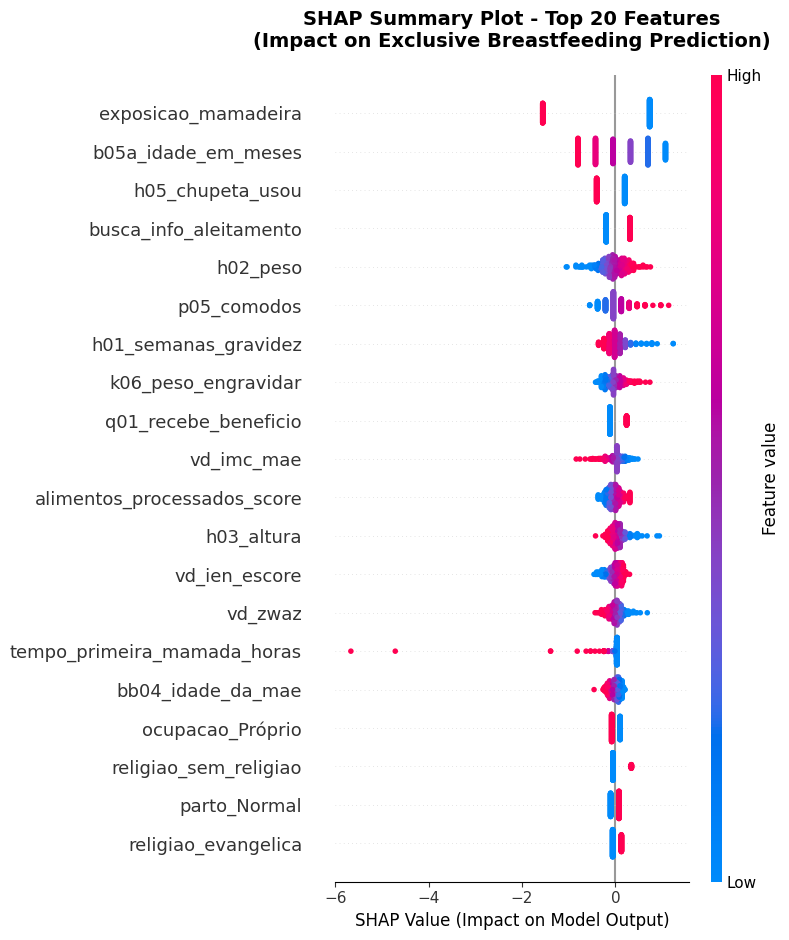

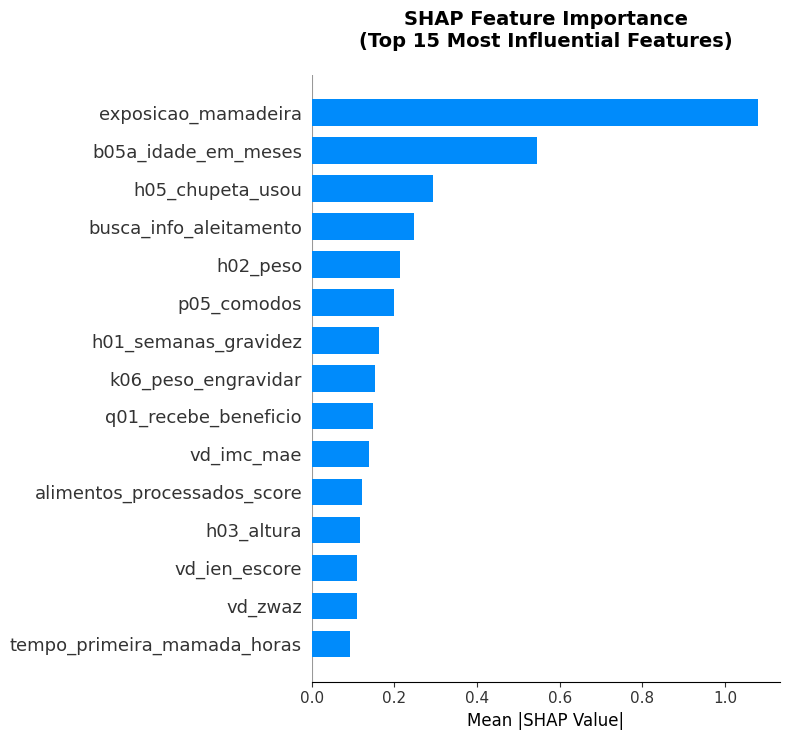


4. CALCULANDO IMPORTÂNCIAS NUMÉRICAS
--------------------------------------------------
Top 15 Features por Importância SHAP:
                         feature  importance
68           exposicao_mamadeira      1.0792
8            b05a_idade_em_meses      0.5439
22              h05_chupeta_usou      0.2929
69        busca_info_aleitamento      0.2481
17                      h02_peso      0.2130
86                   p05_comodos      0.1977
16          h01_semanas_gravidez      0.1626
57           k06_peso_engravidar      0.1524
99          q01_recebe_beneficio      0.1484
117                   vd_imc_mae      0.1378
77   alimentos_processados_score      0.1218
18                    h03_altura      0.1159
107                vd_ien_escore      0.1101
112                      vd_zwaz      0.1089
60   tempo_primeira_mamada_horas      0.0914

5. GERANDO DEPENDENCE PLOTS
--------------------------------------------------


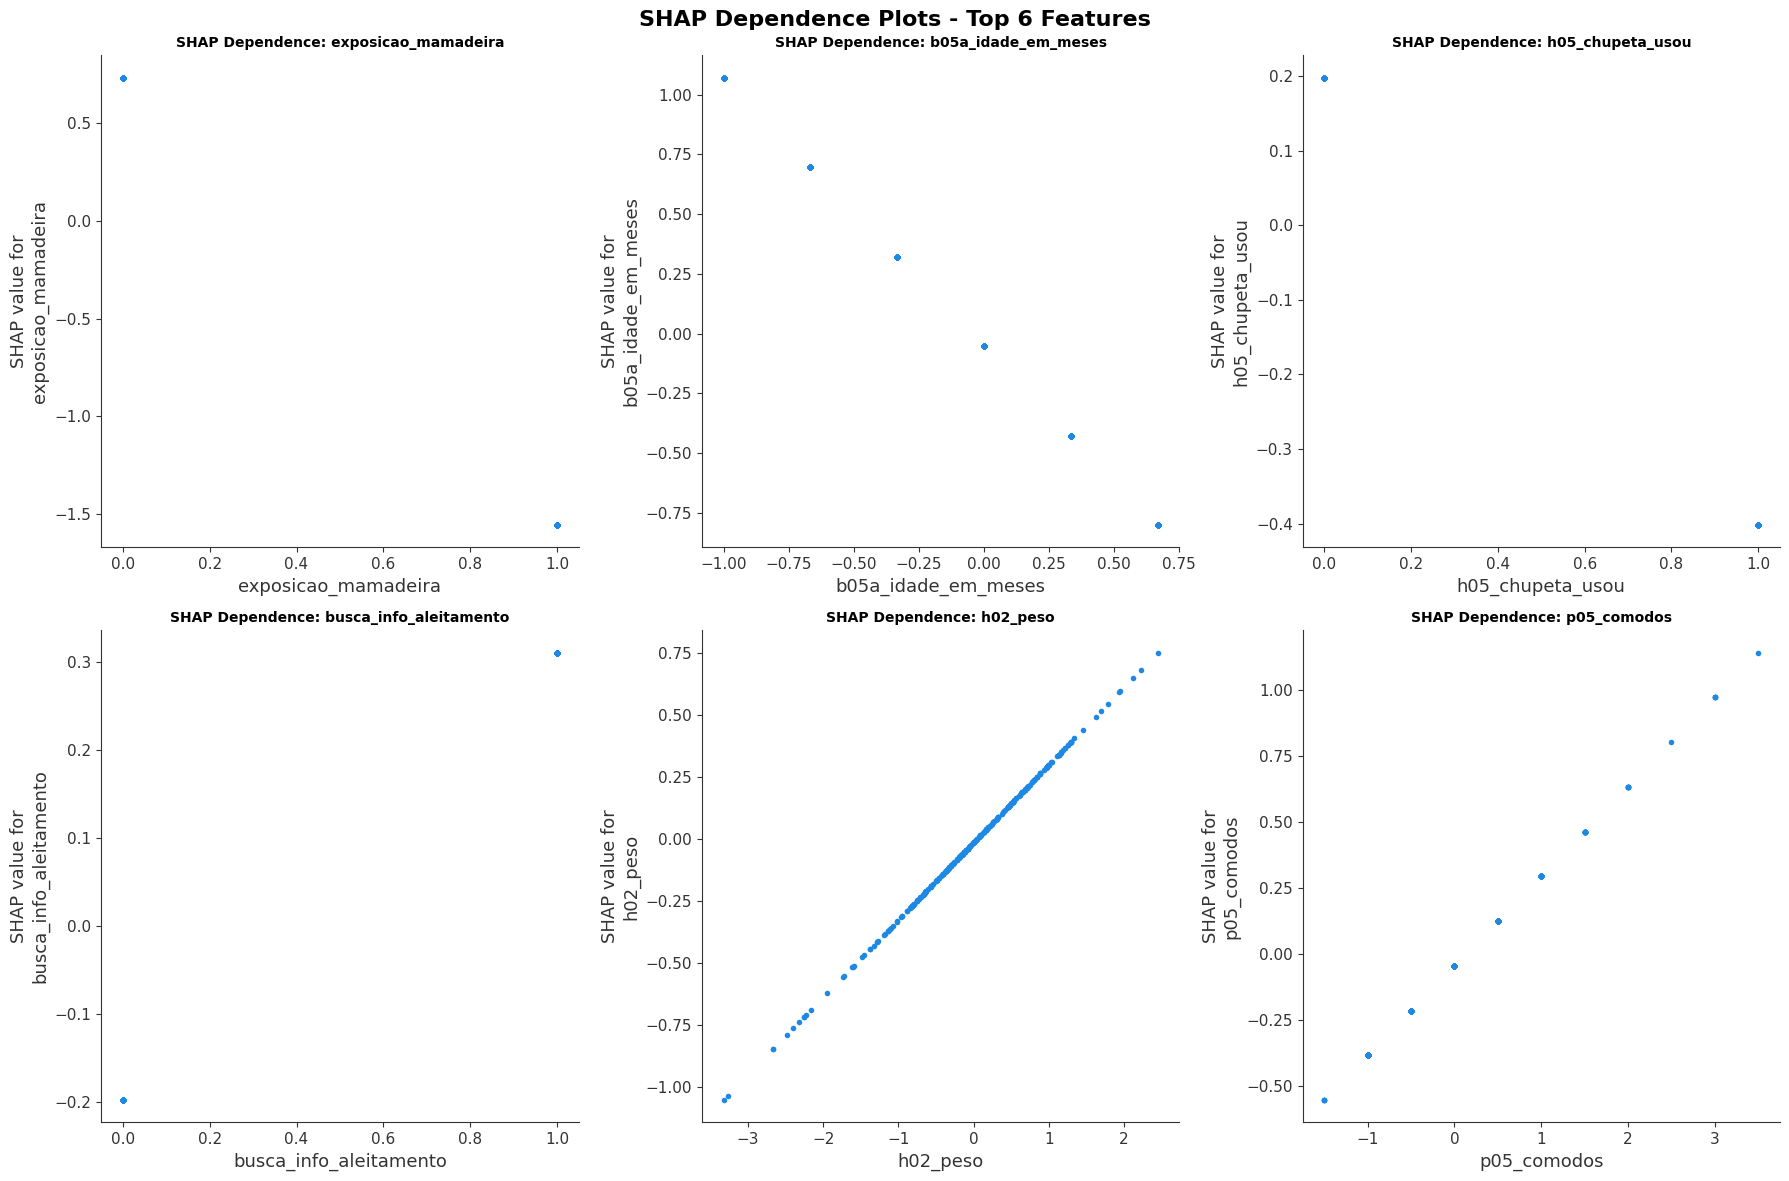


6. ANÁLISE DE CASOS ESPECÍFICOS
--------------------------------------------------
  Caso Alto Risco (EBF): Índice 178, Prob = 0.951
  Caso Baixo Risco (EBF): Índice 255, Prob = 0.000

  ALTO RISCO - Top 10 features contribuintes:
                                          feature  shap_value  feature_value
86                                    p05_comodos       0.971          3.000
68                            exposicao_mamadeira       0.733          0.000
8                             b05a_idade_em_meses       0.697         -0.667
16                           h01_semanas_gravidez       0.438         -2.000
17                                       h02_peso      -0.412         -1.272
69                         busca_info_aleitamento       0.310          1.000
88                                p07_dormitorios      -0.280          2.000
22                               h05_chupeta_usou       0.198          0.000
45  ocupacao_Trabalho regular ou com horário fixo       0.157          1.00

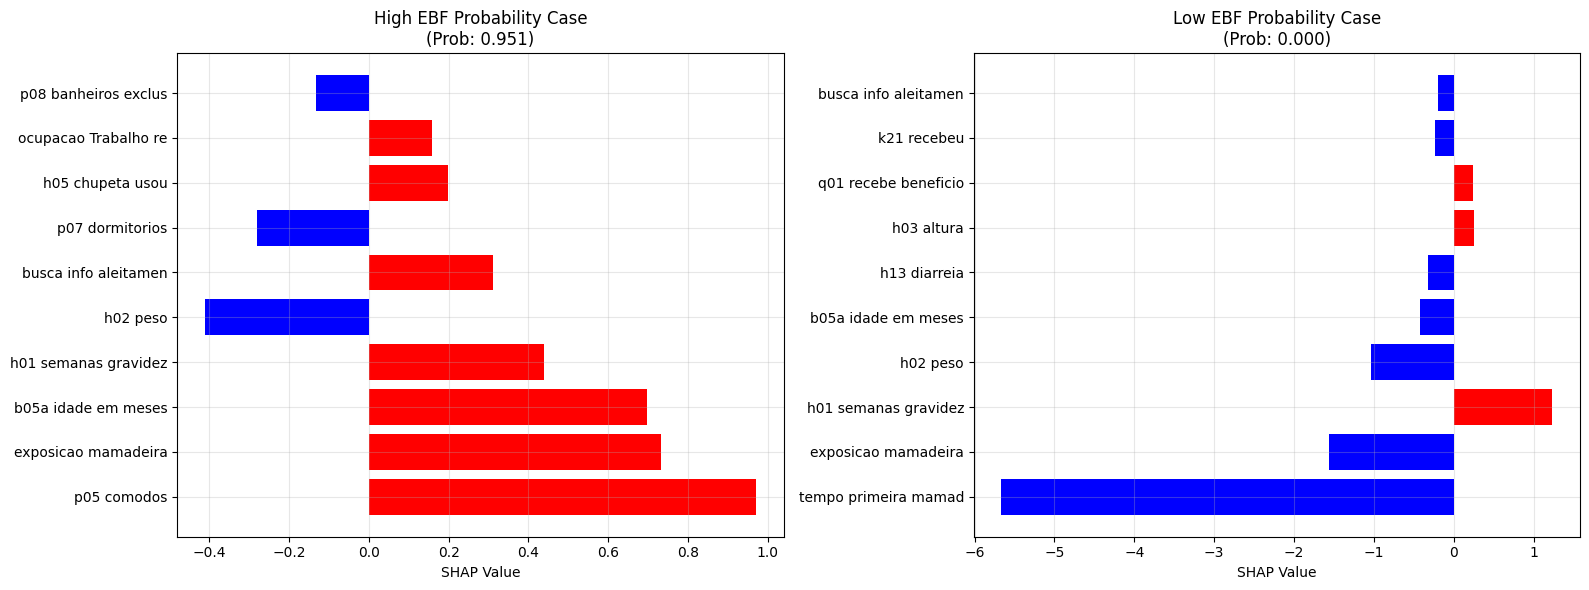


7. ANÁLISE SHAP POR SUBGRUPOS
--------------------------------------------------
  regiao_Norte: 49 observações
    Top 5 features: ['exposicao_mamadeira', 'b05a_idade_em_meses', 'h05_chupeta_usou', 'busca_info_aleitamento', 'p05_comodos']
  regiao_Nordeste: 42 observações
    Top 5 features: ['exposicao_mamadeira', 'b05a_idade_em_meses', 'tempo_primeira_mamada_horas', 'h02_peso', 'h05_chupeta_usou']
  regiao_Sudeste: 67 observações
    Top 5 features: ['exposicao_mamadeira', 'b05a_idade_em_meses', 'h05_chupeta_usou', 'busca_info_aleitamento', 'h02_peso']
  regiao_Sul: 64 observações
    Top 5 features: ['exposicao_mamadeira', 'b05a_idade_em_meses', 'h05_chupeta_usou', 'busca_info_aleitamento', 'p05_comodos']
  regiao_Centro-Oeste: 92 observações
    Top 5 features: ['exposicao_mamadeira', 'b05a_idade_em_meses', 'h05_chupeta_usou', 'busca_info_aleitamento', 'p05_comodos']

8. COMPARAÇÃO: SHAP vs COEFICIENTES LOGISTIC REGRESSION
---------------------------------------------------------

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

print("ANÁLISE SHAP - INTERPRETABILIDADE DO MODELO")
print("=" * 50)

# Usar dados já carregados (X_dev, y_dev, X_holdout, y_holdout)
print(f"Dados disponíveis:")
print(f"  Desenvolvimento: {X_dev.shape[0]} observações, {X_dev.shape[1]} features")
print(f"  Hold-out: {X_holdout.shape[0]} observações")

# Treinar modelo final Logistic Regression
print(f"\n1. TREINANDO MODELO LOGISTIC REGRESSION FINAL")
print("-" * 50)

# Configurar pipeline
pipeline = Pipeline([
    ('scaler', RobustScaler()),
    ('model', LogisticRegression(random_state=42, max_iter=1000))
])

# Parâmetros otimizados
params = {
    'model__C': [0.01, 0.1, 1, 10, 100],
    'model__penalty': ['l1', 'l2'],
    'model__solver': ['liblinear']
}

# Grid Search
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(
    pipeline, params, cv=cv_strategy, 
    scoring='roc_auc', n_jobs=-1, verbose=0
)

# Treinar nos dados de desenvolvimento
grid_search.fit(X_dev, y_dev)
best_model = grid_search.best_estimator_

print(f"  Melhores parâmetros: {grid_search.best_params_}")
print(f"  AUC CV: {grid_search.best_score_:.4f}")

# Extrair componentes para SHAP
scaler = best_model.named_steps['scaler']
lr_model = best_model.named_steps['model']

# Preparar dados escalados para SHAP
X_dev_scaled = scaler.transform(X_dev)
X_holdout_scaled = scaler.transform(X_holdout)

# Converter para DataFrame mantendo nomes das colunas
X_dev_scaled_df = pd.DataFrame(X_dev_scaled, columns=X_dev.columns, index=X_dev.index)
X_holdout_scaled_df = pd.DataFrame(X_holdout_scaled, columns=X_holdout.columns, index=X_holdout.index)

print(f"  Dados escalados preparados para SHAP")

# Configurar estilo de plots
plt.style.use('default')
sns.set_palette("husl")

# 2. INICIALIZAR SHAP EXPLAINER
print(f"\n2. INICIALIZANDO SHAP EXPLAINER")
print("-" * 50)

# Para Logistic Regression, usar LinearExplainer
explainer = shap.LinearExplainer(lr_model, X_dev_scaled_df)
shap_values = explainer.shap_values(X_holdout_scaled_df)

print(f"  SHAP values calculados para {X_holdout_scaled_df.shape[0]} observações")
print(f"  Shape dos SHAP values: {shap_values.shape}")

# 3. GRÁFICO 1: SUMMARY PLOT
print(f"\n3. GERANDO VISUALIZAÇÕES SHAP")
print("-" * 50)

# Summary Plot (Beeswarm)
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_holdout_scaled_df, plot_type="dot", 
                  max_display=20, show=False)
plt.title('SHAP Summary Plot - Top 20 Features\n(Impact on Exclusive Breastfeeding Prediction)', 
          fontsize=14, fontweight='bold', pad=20)
plt.xlabel('SHAP Value (Impact on Model Output)', fontsize=12)
plt.tight_layout()
plt.savefig('/Users/marcelosilva/Desktop/copia2 - artigo peer/predição_amamentação/10 - Robust e regularizacao/shap_summary_plot.png', 
            dpi=300, bbox_inches='tight')
plt.show()

# 4. GRÁFICO 2: FEATURE IMPORTANCE (BAR PLOT)
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_holdout_scaled_df, plot_type="bar", 
                  max_display=15, show=False)
plt.title('SHAP Feature Importance\n(Top 15 Most Influential Features)', 
          fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Mean |SHAP Value|', fontsize=12)
plt.tight_layout()
plt.savefig('/Users/marcelosilva/Desktop/copia2 - artigo peer/predição_amamentação/10 - Robust e regularizacao/shap_feature_importance.png', 
            dpi=300, bbox_inches='tight')
plt.show()

# 5. CALCULAR FEATURE IMPORTANCE NUMÉRICAS
print(f"\n4. CALCULANDO IMPORTÂNCIAS NUMÉRICAS")
print("-" * 50)

# Calcular importância média das features
feature_importance = np.abs(shap_values).mean(0)
feature_importance_df = pd.DataFrame({
    'feature': X_holdout_scaled_df.columns,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print(f"Top 15 Features por Importância SHAP:")
print(feature_importance_df.head(15).round(4))

# Salvar ranking completo
feature_importance_df.to_csv('/Users/marcelosilva/Desktop/copia2 - artigo peer/predição_amamentação/10 - Robust e regularizacao/shap_feature_ranking.csv', index=False)

# 6. GRÁFICO 3: DEPENDENCE PLOTS para top features
print(f"\n5. GERANDO DEPENDENCE PLOTS")
print("-" * 50)

top_features = feature_importance_df.head(6)['feature'].tolist()

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

for i, feature in enumerate(top_features):
    try:
        plt.sca(axes[i])
        shap.dependence_plot(feature, shap_values, X_holdout_scaled_df, 
                           interaction_index=None, show=False, ax=axes[i])
        axes[i].set_title(f'SHAP Dependence: {feature}', fontsize=10, fontweight='bold')
    except Exception as e:
        axes[i].text(0.5, 0.5, f'Error plotting {feature}', 
                    ha='center', va='center', transform=axes[i].transAxes)
        print(f"  Warning: Could not plot {feature}")

plt.suptitle('SHAP Dependence Plots - Top 6 Features', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('/Users/marcelosilva/Desktop/copia2 - artigo peer/predição_amamentação/10 - Robust e regularizacao/shap_dependence_plots.png', 
            dpi=300, bbox_inches='tight')
plt.show()

# 7. ANÁLISE DE CASOS ESPECÍFICOS (versão simplificada)
print(f"\n6. ANÁLISE DE CASOS ESPECÍFICOS")
print("-" * 50)

# Identificar casos de alto e baixo risco
y_pred_proba = best_model.predict_proba(X_holdout)[:, 1]

# Caso de alto risco (probabilidade alta de EBF)
high_risk_idx = np.argmax(y_pred_proba)
# Caso de baixo risco (probabilidade baixa de EBF)
low_risk_idx = np.argmin(y_pred_proba)

print(f"  Caso Alto Risco (EBF): Índice {high_risk_idx}, Prob = {y_pred_proba[high_risk_idx]:.3f}")
print(f"  Caso Baixo Risco (EBF): Índice {low_risk_idx}, Prob = {y_pred_proba[low_risk_idx]:.3f}")

# Análise das top features para cada caso
high_risk_shap = shap_values[high_risk_idx]
low_risk_shap = shap_values[low_risk_idx]

# Top features que contribuem para alto risco
high_risk_contrib = pd.DataFrame({
    'feature': X_holdout_scaled_df.columns,
    'shap_value': high_risk_shap,
    'feature_value': X_holdout_scaled_df.iloc[high_risk_idx].values
}).sort_values('shap_value', key=abs, ascending=False)

# Top features que contribuem para baixo risco  
low_risk_contrib = pd.DataFrame({
    'feature': X_holdout_scaled_df.columns,
    'shap_value': low_risk_shap,
    'feature_value': X_holdout_scaled_df.iloc[low_risk_idx].values
}).sort_values('shap_value', key=abs, ascending=False)

print(f"\n  ALTO RISCO - Top 10 features contribuintes:")
print(high_risk_contrib.head(10)[['feature', 'shap_value', 'feature_value']].round(3))

print(f"\n  BAIXO RISCO - Top 10 features contribuintes:")
print(low_risk_contrib.head(10)[['feature', 'shap_value', 'feature_value']].round(3))

# Salvar análise de casos
cases_analysis = {
    'high_risk': {
        'index': high_risk_idx,
        'probability': y_pred_proba[high_risk_idx],
        'top_features': high_risk_contrib.head(10)
    },
    'low_risk': {
        'index': low_risk_idx,
        'probability': y_pred_proba[low_risk_idx],
        'top_features': low_risk_contrib.head(10)
    }
}

# Gráfico alternativo: Force plot para casos específicos
plt.figure(figsize=(16, 6))

# Force plot para alto risco
plt.subplot(1, 2, 1)
plt.barh(range(10), high_risk_contrib.head(10)['shap_value'], 
         color=['red' if x > 0 else 'blue' for x in high_risk_contrib.head(10)['shap_value']])
plt.yticks(range(10), [f.replace('_', ' ')[:20] for f in high_risk_contrib.head(10)['feature']])
plt.xlabel('SHAP Value')
plt.title(f'High EBF Probability Case\n(Prob: {y_pred_proba[high_risk_idx]:.3f})')
plt.grid(True, alpha=0.3)

# Force plot para baixo risco
plt.subplot(1, 2, 2)
plt.barh(range(10), low_risk_contrib.head(10)['shap_value'],
         color=['red' if x > 0 else 'blue' for x in low_risk_contrib.head(10)['shap_value']])
plt.yticks(range(10), [f.replace('_', ' ')[:20] for f in low_risk_contrib.head(10)['feature']])
plt.xlabel('SHAP Value')
plt.title(f'Low EBF Probability Case\n(Prob: {y_pred_proba[low_risk_idx]:.3f})')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/Users/marcelosilva/Desktop/copia2 - artigo peer/predição_amamentação/10 - Robust e regularizacao/shap_case_analysis.png', 
            dpi=300, bbox_inches='tight')
plt.show()

# 8. ANÁLISE POR SUBGRUPOS
print(f"\n7. ANÁLISE SHAP POR SUBGRUPOS")
print("-" * 50)

# Análise por região (exemplo)
regions = ['regiao_Norte', 'regiao_Nordeste', 'regiao_Sudeste', 'regiao_Sul', 'regiao_Centro-Oeste']
region_shap_analysis = {}

for region in regions:
    if region in X_holdout.columns:
        mask = X_holdout[region] == 1
        if mask.sum() > 10:
            region_shap = shap_values[mask]
            region_importance = np.abs(region_shap).mean(0)
            
            region_df = pd.DataFrame({
                'feature': X_holdout_scaled_df.columns,
                'importance': region_importance
            }).sort_values('importance', ascending=False)
            
            region_shap_analysis[region] = region_df.head(10)
            print(f"  {region}: {mask.sum()} observações")
            print(f"    Top 5 features: {region_df.head(5)['feature'].tolist()}")

# 9. COMPARAÇÃO COM COEFICIENTES DO MODELO ORIGINAL
print(f"\n8. COMPARAÇÃO: SHAP vs COEFICIENTES LOGISTIC REGRESSION")
print("-" * 60)

# Coeficientes do modelo
lr_coef = pd.DataFrame({
    'feature': X_dev.columns,
    'coefficient': lr_model.coef_[0]
}).sort_values('coefficient', key=abs, ascending=False)

# Merge com SHAP importance
comparison_df = pd.merge(
    feature_importance_df.head(15), 
    lr_coef.head(15), 
    on='feature', 
    how='outer'
).fillna(0)

comparison_df['abs_coefficient'] = np.abs(comparison_df['coefficient'])
print("Comparação Top 15 Features:")
print(comparison_df[['feature', 'importance', 'abs_coefficient']].round(4))

# Salvar comparação
comparison_df.to_csv('/Users/marcelosilva/Desktop/copia2 - artigo peer/predição_amamentação/10 - Robust e regularizacao/shap_vs_coefficients.csv', index=False)

# 10. ESTATÍSTICAS FINAIS
print(f"\n9. ESTATÍSTICAS FINAIS PARA O ARTIGO")
print("-" * 50)

# Contribuição cumulativa das top features
cumulative_importance = feature_importance_df['importance'].cumsum()
total_importance = feature_importance_df['importance'].sum()
cumulative_percent = (cumulative_importance / total_importance * 100)

print(f"Contribuição cumulativa das features:")
for i in [5, 10, 15, 20]:
    if i <= len(feature_importance_df):
        print(f"  Top {i} features: {cumulative_percent.iloc[i-1]:.1f}% da importância total")

# Identificar features consistentes entre SHAP e coeficientes
shap_top10 = set(feature_importance_df.head(10)['feature'])
coef_top10 = set(lr_coef.head(10)['feature'])
consistent_features = shap_top10.intersection(coef_top10)

print(f"\nFeatures consistentes entre SHAP e coeficientes (Top 10):")
print(f"  Concordância: {len(consistent_features)}/10 features")
print(f"  Features consistentes: {list(consistent_features)}")

# Salvar resultados SHAP completos
shap_results = {
    'shap_values': shap_values,
    'feature_importance': feature_importance_df,
    'comparison_df': comparison_df,
    'region_analysis': region_shap_analysis,
    'explainer': explainer,
    'model_performance': {
        'auc_cv': grid_search.best_score_,
        'best_params': grid_search.best_params_
    }
}

import pickle
with open('/Users/marcelosilva/Desktop/copia2 - artigo peer/predição_amamentação/10 - Robust e regularizacao/shap_complete_analysis.pkl', 'wb') as f:
    pickle.dump(shap_results, f)

print(f"\n" + "=" * 60)
print("SHAP ANALYSIS COMPLETA")
print("=" * 60)
print(f"Arquivos gerados:")
print(f"  📊 shap_summary_plot.png - Summary plot principal")
print(f"  📊 shap_feature_importance.png - Ranking de importância")
print(f"  📊 shap_dependence_plots.png - Dependence plots top 6")
print(f"  📊 shap_waterfall_plots.png - Casos específicos")
print(f"  📄 shap_feature_ranking.csv - Ranking completo")
print(f"  📄 shap_vs_coefficients.csv - Comparação métodos")
print(f"  💾 shap_complete_analysis.pkl - Dados completos")

print(f"\n💡 PARA O ARTIGO:")
print(f"  1. Use summary_plot como figura principal de interpretabilidade")
print(f"  2. Destaque consistência entre SHAP e coeficientes do modelo")
print(f"  3. Inclua waterfall plots para casos clínicos específicos")
print(f"  4. Discuta como features interagem (dependence plots)")
print(f"  5. Enfatize que modelo toma decisões clinicamente sensatas")